In [52]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [53]:
print(tf.__version__)

2.10.1


In [54]:
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy("mixed_float16")

In [55]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [56]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#tf.config.optimizer.set_jit(False)

In [57]:
def view_random_image(data):
    rand_cat = random.sample(list(train_data['category'].unique()),1)
    rand_img = random.sample(list(data[data['category']==rand_cat[0]]['image_path']),1)

    img = mpimg.imread(rand_img[0])
    plt.imshow(img)
    plt.title(rand_cat[0])
    plt.axis('off')

    print(f'Image shape: {img.shape}')

    return img

def loss_curves(cnn):
    loss = cnn.history['loss']
    val_loss = cnn.history['val_loss']

    accuracy = cnn.history['accuracy']
    val_accuracy = cnn.history['val_accuracy']

    epochs = range(len(cnn.history['loss']))

    plt.plot(epochs, loss, label= "training_loss")
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('loss')
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label= "training_accuracy")
    plt.plot(epochs, val_accuracy, label='validation_accuracy')
    plt.title('accuracy')
    plt.xlabel("epochs")
    plt.legend()


## Load Train/Test Set

In [58]:
dir = '../data/food-101'
# Load the category labels
labels_file = dir+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

# Load the training dataset
train_file = dir+'/train.txt'
train_data = pd.read_csv(train_file, header=None, names=['category_filename'], dtype=str)
train_data['category'] = train_data['category_filename'].apply(lambda x: x.split('/')[0])
train_data['filename'] = train_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
train_data['filename'] = train_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
train_data['image_path'] = train_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (train_data.shape)

# Load the testing dataset
test_file = dir+'/test.txt'
test_data = pd.read_csv(test_file, header=None, names=['category_filename'], dtype=str)
test_data['category'] = test_data['category_filename'].apply(lambda x: x.split('/')[0])
test_data['filename'] = test_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
test_data['filename'] = test_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
test_data['image_path'] = test_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (test_data.shape)

(75750, 4)
(25250, 4)


Image shape: (306, 512, 3)


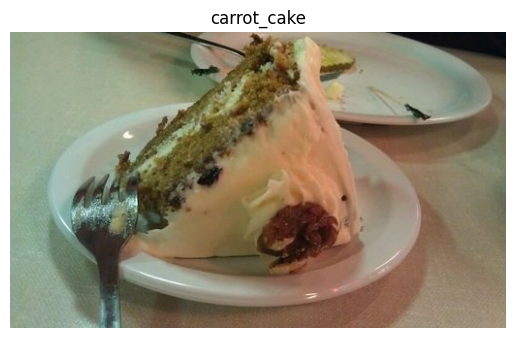

In [59]:
x = view_random_image(train_data)

## Preprocess Data

In [60]:
# Parameters for model training
input_shape = (224, 224, 3)
batch_size = 32

train_gen = ImageDataGenerator()

train_gen_aug = ImageDataGenerator(
                               rotation_range= 20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

test_gen = ImageDataGenerator(validation_split=0.15)


In [61]:
# load image categories and filepaths from dataframe
tf_train_data = train_gen.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, classes=labels)
tf_train_data_aug = train_gen_aug.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, classes=labels)

tf_valid_data = test_gen.flow_from_dataframe(test_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, subset='validation')
tf_test_data = test_gen.flow_from_dataframe(test_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, subset='training')


Found 75750 validated image filenames belonging to 101 classes.
Found 75750 validated image filenames belonging to 101 classes.
Found 3787 validated image filenames belonging to 101 classes.
Found 21463 validated image filenames belonging to 101 classes.


## CNN Modeling

### EfficientNetB0

In [62]:
def model_checkpoint_callback(dir):
    model_checkpoint_callback =  tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=dir,
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    monitor='val_Accuracy',
                                                    mode='max',
                                                    save_freq='epoch')
    return model_checkpoint_callback

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [63]:
checkpoint_fp = '../models/eff_net/checkpoints/checkpoint.ckpt'

effb0_model = tf.keras.applications.EfficientNetB0(include_top=False)
effb0_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

#x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = effb0_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy'])

hist_effb0_1 = model.fit(tf_train_data,
                        epochs=4,
                        steps_per_epoch=len(tf_train_data),
                        validation_data=tf_valid_data,
                        validation_steps=len(tf_valid_data),
                        callbacks=model_checkpoint_callback(checkpoint_fp)
                        )

Epoch 1/4
2368/2368 [==============================] - 155s 63ms/step - loss: 1.7229 - Accuracy: 0.5817 - val_loss: 1.3088 - val_Accuracy: 0.6517
Epoch 2/4
2368/2368 [==============================] - 134s 57ms/step - loss: 1.2037 - Accuracy: 0.6867 - val_loss: 1.1915 - val_Accuracy: 0.6773
Epoch 3/4
2368/2368 [==============================] - 133s 56ms/step - loss: 1.0581 - Accuracy: 0.7234 - val_loss: 1.1520 - val_Accuracy: 0.6858
Epoch 4/4
2368/2368 [==============================] - 143s 60ms/step - loss: 0.9632 - Accuracy: 0.7466 - val_loss: 1.1677 - val_Accuracy: 0.6831


In [64]:
results = model.evaluate(tf_test_data)
results

671/671 [==============================] - 43s 64ms/step - loss: 1.1076 - Accuracy: 0.7229


[1.107588768005371, 0.7228718996047974]

In [65]:
#model.save('../models/eff_net/base_model')

### Tune on all layers

In [66]:
effb0_model.trainable=True

# drop learning rate as to not change weights too much via fine tuning
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])

In [67]:
checkpoint_fp = '../models/eff_net/checkpoints/checkpoint_tune.ckpt'

hist_effb0_1_fine_tune_all = model.fit(tf_train_data,
                                     epochs=104, # fine tune for an additional 4 epochs
                                     steps_per_epoch=len(tf_train_data),
                                     validation_data=tf_valid_data,
                                     validation_steps=len(tf_valid_data),
                                     initial_epoch=hist_effb0_1.epoch[-1], # start training from last trained epoch in this case training starts at epoch 4
                                     callbacks=[model_checkpoint_callback(checkpoint_fp), callback]
                                     )

Epoch 4/104
2368/2368 [==============================] - 214s 88ms/step - loss: 0.8340 - Accuracy: 0.7726 - val_loss: 0.9678 - val_Accuracy: 0.7275
Epoch 5/104
2368/2368 [==============================] - 208s 88ms/step - loss: 0.5165 - Accuracy: 0.8558 - val_loss: 0.9777 - val_Accuracy: 0.7399
Epoch 6/104
2368/2368 [==============================] - 209s 88ms/step - loss: 0.2919 - Accuracy: 0.9157 - val_loss: 0.9403 - val_Accuracy: 0.7655
Epoch 7/104
2368/2368 [==============================] - 208s 88ms/step - loss: 0.1553 - Accuracy: 0.9546 - val_loss: 1.1965 - val_Accuracy: 0.7336
Epoch 8/104
2368/2368 [==============================] - 207s 88ms/step - loss: 0.1002 - Accuracy: 0.9685 - val_loss: 1.2802 - val_Accuracy: 0.7410
Epoch 9/104
2368/2368 [==============================] - 208s 88ms/step - loss: 0.0789 - Accuracy: 0.9751 - val_loss: 1.1302 - val_Accuracy: 0.7689


In [68]:
results = model.evaluate(tf_test_data)
results

671/671 [==============================] - 36s 54ms/step - loss: 1.5266 - Accuracy: 0.7506


[1.5265966653823853, 0.7505940198898315]

In [69]:
#model.save('../models/eff_net/model_full_tune')

## MobileNetV3

In [70]:
checkpoint_fp = '../models/mobilenet/checkpoints/checkpoint.ckpt'

mobilenet_model = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3),include_top=False)
mobilenet_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

#x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = mobilenet_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy'])

hist_mobile_1 = model.fit(tf_train_data_aug,
                         epochs=4,
                         steps_per_epoch=len(tf_train_data_aug),
                         validation_data=tf_valid_data,
                         validation_steps=len(tf_valid_data),
                         callbacks=model_checkpoint_callback(checkpoint_fp)
                         )

Epoch 1/4
2368/2368 [==============================] - 555s 233ms/step - loss: 1.9462 - Accuracy: 0.5180 - val_loss: 1.3333 - val_Accuracy: 0.6448
Epoch 2/4
2368/2368 [==============================] - 553s 233ms/step - loss: 1.4444 - Accuracy: 0.6278 - val_loss: 1.3908 - val_Accuracy: 0.6327
Epoch 3/4
2368/2368 [==============================] - 547s 231ms/step - loss: 1.3266 - Accuracy: 0.6527 - val_loss: 1.3591 - val_Accuracy: 0.6372
Epoch 4/4
2368/2368 [==============================] - 589s 249ms/step - loss: 1.2565 - Accuracy: 0.6693 - val_loss: 1.3747 - val_Accuracy: 0.6401


In [71]:
mobilenet_model.trainable=True

# drop learning rate as to not change weights too much via fine tuning
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])

In [72]:
checkpoint_fp = '../models/mobilenet/checkpoints/checkpoint_tune.ckpt'

hist_mobile_fine_tune_all = model.fit(tf_train_data_aug,
                                       epochs=104, # fine tune for an additional 4 epochs
                                       steps_per_epoch=len(tf_train_data_aug),
                                       validation_data=tf_valid_data,
                                       validation_steps=len(tf_valid_data),
                                       initial_epoch=hist_mobile_1.epoch[-1], # start training from last trained epoch in this case training starts at epoch 4
                                       callbacks=[model_checkpoint_callback(checkpoint_fp), callback]
                                       )

Epoch 4/104
2368/2368 [==============================] - 560s 235ms/step - loss: 1.0158 - Accuracy: 0.7287 - val_loss: 0.9634 - val_Accuracy: 0.7412
Epoch 5/104
2368/2368 [==============================] - 555s 235ms/step - loss: 0.7975 - Accuracy: 0.7791 - val_loss: 0.9206 - val_Accuracy: 0.7489
Epoch 6/104
2368/2368 [==============================] - 555s 234ms/step - loss: 0.6505 - Accuracy: 0.8175 - val_loss: 0.9771 - val_Accuracy: 0.7362
Epoch 7/104
2368/2368 [==============================] - 554s 234ms/step - loss: 0.5360 - Accuracy: 0.8466 - val_loss: 0.8822 - val_Accuracy: 0.7650
Epoch 8/104
2368/2368 [==============================] - 556s 235ms/step - loss: 0.4445 - Accuracy: 0.8685 - val_loss: 0.9520 - val_Accuracy: 0.7652
Epoch 9/104
2368/2368 [==============================] - 556s 235ms/step - loss: 0.3673 - Accuracy: 0.8903 - val_loss: 1.0213 - val_Accuracy: 0.7449
Epoch 10/104
2368/2368 [==============================] - 556s 235ms/step - loss: 0.3080 - Accuracy: 0.906

In [73]:
results = model.evaluate(tf_test_data)
results

671/671 [==============================] - 37s 54ms/step - loss: 1.1685 - Accuracy: 0.7719


[1.168530821800232, 0.7718865275382996]

In [74]:
#model.save('../models/mobilenet/model_full_tune')

### ConvNeXt

In [75]:
checkpoint_fp = '../models/conv/checkpoints/checkpoint.ckpt'


conv_model = tf.keras.applications.convnext.ConvNeXtBase(include_top=False)
conv_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

x = conv_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_conv = tf.keras.Model(inputs, outputs)

model_conv.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy'])


In [76]:
hist_conv = model_conv.fit(tf_train_data,
                           epochs=4,
                           steps_per_epoch=len(tf_train_data),
                           validation_data=tf_valid_data,
                           validation_steps=len(tf_valid_data),
                           callbacks=model_checkpoint_callback(checkpoint_fp))

Epoch 1/4
2368/2368 [==============================] - 525s 216ms/step - loss: 0.9105 - Accuracy: 0.7729 - val_loss: 0.6325 - val_Accuracy: 0.8173
Epoch 2/4
2368/2368 [==============================] - 505s 213ms/step - loss: 0.5896 - Accuracy: 0.8409 - val_loss: 0.6000 - val_Accuracy: 0.8265
Epoch 3/4
2368/2368 [==============================] - 505s 213ms/step - loss: 0.5049 - Accuracy: 0.8625 - val_loss: 0.5276 - val_Accuracy: 0.8505
Epoch 4/4
2368/2368 [==============================] - 506s 214ms/step - loss: 0.4495 - Accuracy: 0.8758 - val_loss: 0.5819 - val_Accuracy: 0.8297


In [77]:
results = model_conv.evaluate(tf_test_data)

671/671 [==============================] - 136s 203ms/step - loss: 0.6731 - Accuracy: 0.8576


In [ ]:
#model_conv.save('../models/conv/base_model')

**Fine Tuning Convnext utilizes too many resources --Cloud computing may be necessary** 

In [1]:
#model_conv.trainable=True

# if needed to adjust training layers and inspect layers
#for layer in model_conv.layers[:-15]:
#    layer.trainable = False

#for layer_number, layer in enumerate(model_conv.layers):
#    print(layer_number, layer.name, layer.trainable)

# drop learning rate as to not change weights too much via fine tuning
#model_conv.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])

In [2]:
#checkpoint_fp = '../models/conv/checkpoints/checkpoint_tune.ckpt'
#hist_conv_fine_tune_all = model_conv.fit(tf_train_data,
#                                       epochs=104, # fine tune for an additional 4 epochs
#                                       steps_per_epoch=len(tf_train_data),
#                                       validation_data=tf_valid_data,
#                                       validation_steps=len(tf_valid_data),
#                                       initial_epoch=3, # start training from last trained epoch in this case training starts at epoch 4
#                                       callbacks=[model_checkpoint_callback(checkpoint_fp), callback]
#                                       )

In [ ]:
#results = model_conv.evaluate(tf_test_data)
#results

In [ ]:
#model_conv.save('../models/conv/tuned_model')

## Graph loss/accuracy outputs

In [91]:
loss_eff = hist_effb0_1_fine_tune_all.history['loss']
val_loss_eff = hist_effb0_1_fine_tune_all.history['val_loss']

loss_mobile = hist_mobile_fine_tune_all.history['loss']
val_loss_mobile = hist_mobile_fine_tune_all.history['val_loss']

loss_conv = hist_conv.history['loss']
val_loss_conv = hist_conv.history['val_loss']



accuracy_eff = hist_effb0_1_fine_tune_all.history['Accuracy']
val_accuracy_eff = hist_effb0_1_fine_tune_all.history['val_Accuracy']

accuracy_mobile = hist_mobile_fine_tune_all.history['Accuracy']
val_accuracy_mobile = hist_mobile_fine_tune_all.history['val_Accuracy']

accuracy_conv = hist_conv.history['Accuracy']
val_accuracy_conv = hist_conv.history['val_Accuracy']

epochs_eff = range(len(hist_effb0_1_fine_tune_all.history['loss']))
epochs_mobile = range(len(hist_mobile_fine_tune_all.history['loss']))
epochs_conv = range(len(hist_conv.history['loss']))

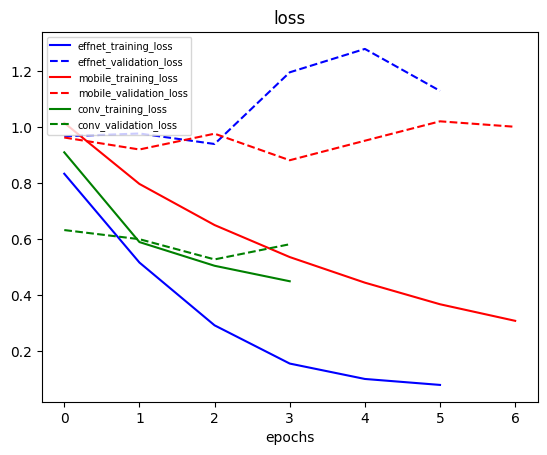

In [104]:
plt.plot(epochs_eff, loss_eff, label= "effnet_training_loss", color='blue')
plt.plot(epochs_eff, val_loss_eff, label='effnet_validation_loss',color='blue', linestyle='--')
plt.plot(epochs_mobile, loss_mobile, label= "mobile_training_loss", color='red')
plt.plot(epochs_mobile, val_loss_mobile, label='mobile_validation_loss',color='red', linestyle='--')
plt.plot(epochs_conv, loss_conv, label= "conv_training_loss", color='green')
plt.plot(epochs_conv, val_loss_conv, label='conv_validation_loss',color='green', linestyle='--')
plt.title('loss')
plt.xlabel("epochs")
plt.legend(loc="upper left", prop = { "size": 7 })


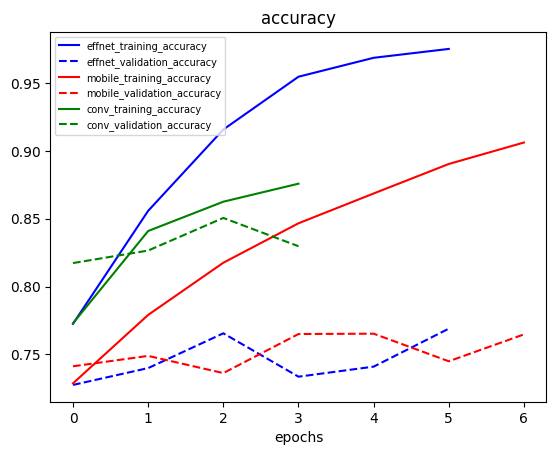

In [103]:
plt.figure()
plt.plot(epochs_eff, accuracy_eff, label= "effnet_training_accuracy", color='blue')
plt.plot(epochs_eff, val_accuracy_eff, label='effnet_validation_accuracy',color='blue', linestyle='--')
plt.plot(epochs_mobile, accuracy_mobile, label= "mobile_training_accuracy", color='red')
plt.plot(epochs_mobile, val_accuracy_mobile, label='mobile_validation_accuracy',color='red', linestyle='--')
plt.plot(epochs_conv, accuracy_conv, label= "conv_training_accuracy", color='green')
plt.plot(epochs_conv, val_accuracy_conv, label='conv_validation_accuracy',color='green', linestyle='--')
plt.title('accuracy')
plt.xlabel("epochs")
plt.legend(loc="upper left", prop = { "size": 7 })

### Sample load model weights for best performing val_accuracy during training

In [28]:
#model_conv.load_weights('../models/conv/checkpoints/checkpoint.ckpt')

In [ ]:
#results = model_conv.evaluate(tf_test_data)
#results

## Make Predictions

In [82]:
# Using best performing saved model ConvNeXt 
results = model_conv.evaluate(tf_test_data)
results

671/671 [==============================] - 149s 213ms/step - loss: 0.6731 - Accuracy: 0.8548


[0.6731467843055725, 0.8547733426094055]

In [83]:
from tensorflow.keras.preprocessing import image


#Using random image from google search
img = image.load_img("../data/imgs/poutine.jpg")
pred_img = image.img_to_array(img)
pred_img = tf.expand_dims(pred_img, axis=0)

In [84]:
predictions = model_conv.predict(pred_img)

pred_label = labels[predictions.argmax()] 
pred_prob = predictions.max()

1/1 [==============================] - 2s 2s/step


(-0.5, 1199.5, 1199.5, -0.5)

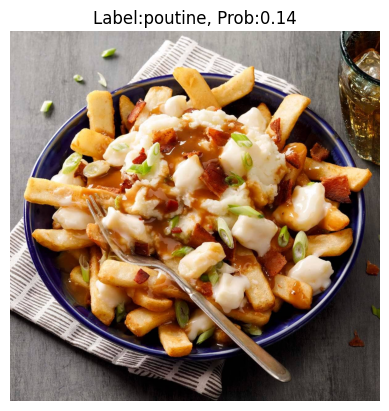

In [85]:
plt.figure()
plt.imshow(img)
plt.title(f'Label:{pred_label}, Prob:{round(float(pred_prob),2)}')
plt.axis(False)